In [1]:
from PIL import Image
import numpy as np
from deeplabv3 import DeepLabModel
from trimap import trimap
# import tensorflow as tf

# deeplabV3+
#### github: https://github.com/tensorflow/models/tree/master/research/deeplab
#### model: http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz

In [2]:
# !wget  http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz

In [3]:
MODEL = DeepLabModel("deeplabv3_pascal_trainval_2018_01_04.tar.gz")

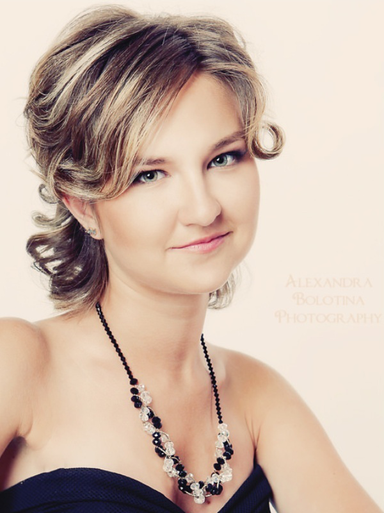

In [19]:
image_url = '06.jpg'
original_im = Image.open(image_url)
resized_im, seg_map = MODEL.run(original_im)
resized_im

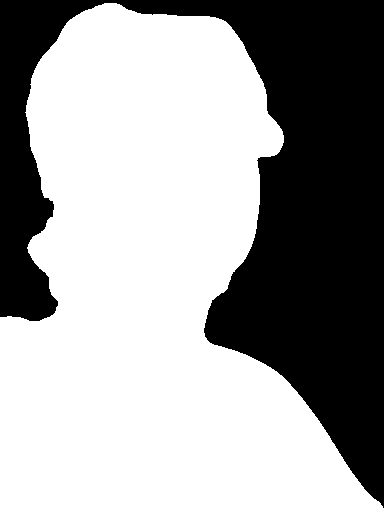

In [20]:
mask = np.equal(seg_map, 15)
mask = mask.astype(int)
mask = mask*255
mask = Image.fromarray(mask.astype(np.uint8))
mask

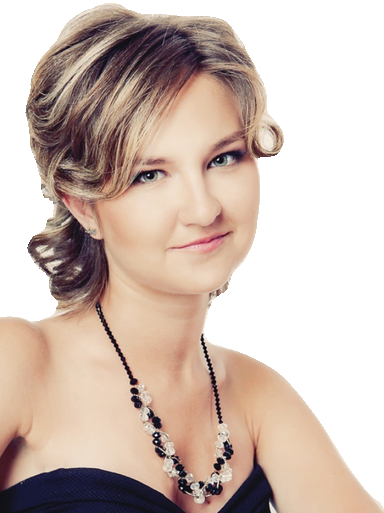

In [21]:
deeplablv3_final = resized_im.copy()
deeplablv3_final.putalpha(mask)
deeplablv3_final

In [22]:
resized_im.save('resized.png')
mask.save('mask.png')
deeplablv3_final.save('deeplablv3_final.png')

# Trimap
#### github: https://github.com/lnugraha/trimap_generator/blob/develop/trimap_module.py

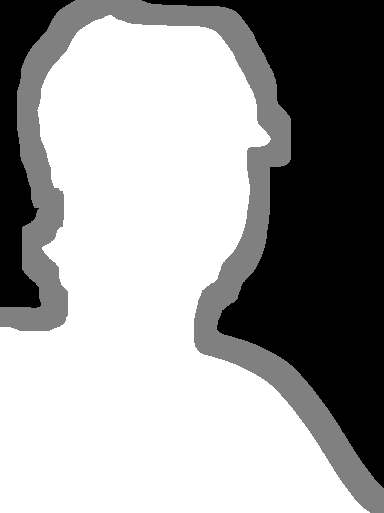

In [7]:
trimap_im = Image.fromarray(trimap(np.array(mask), 20, 10))
trimap_im

In [8]:
trimap_im.save('trimap.png')

# FBA_Matting
#### github: https://github.com/MarcoForte/FBA_Matting
#### model: https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
#### cpu: https://github.com/MarcoForte/FBA_Matting/pull/21/commits/e6620c7e8f9429c633d5ed3d82841a5da36e6e99
#### !pip install gdown

In [9]:
#!git clone https://github.com/MarcoForte/FBA_Matting

In [10]:
# !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1 -O FBA_Matting/FBA.pth

In [11]:
import sys
sys.path.insert(1, 'FBA_Matting')
from networks.models import build_model
from demo import pred
def read_image(name):
    return (np.array(name) / 255.0)
def read_trimap(name):
    trimap_im = np.array(name) / 255.0
    h, w = trimap_im.shape
    trimap = np.zeros((h, w, 2))
    trimap[trimap_im == 1, 1] = 1
    trimap[trimap_im == 0, 0] = 1
    return trimap

In [12]:
class Args:
    encoder = 'resnet50_GN_WS'
    decoder = 'fba_decoder'
    weights = 'FBA_Matting/FBA.pth'
args=Args()
matting_model = build_model(args)

modifying input layer to accept 11 channels


In [13]:
input_resized_im = read_image(resized_im)
input_trimap_im = read_trimap(trimap_im)

In [14]:
fg, bg, alpha = pred(input_resized_im, input_trimap_im, matting_model)

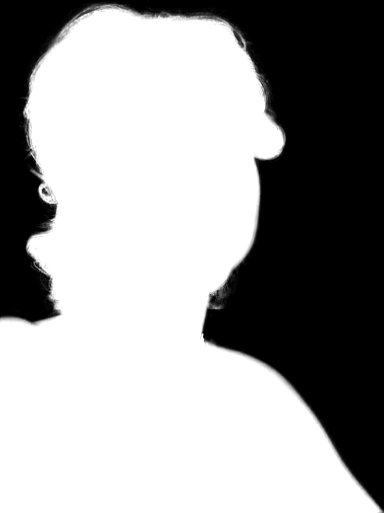

In [15]:
alpha = Image.fromarray((alpha*255).astype(np.uint8))
alpha

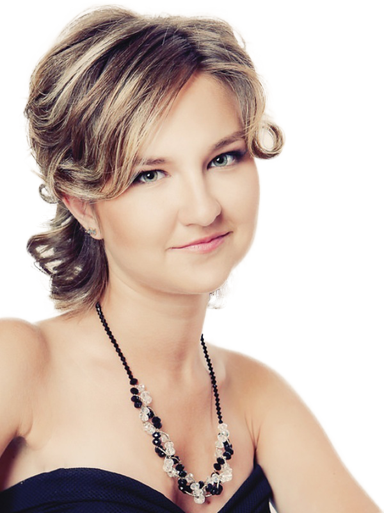

In [16]:
final = Image.fromarray((input_resized_im*255).astype(np.uint8))
final.putalpha(alpha)
final

In [17]:
alpha.save('alpha.png')
final.save('final.png')